# Istanbul Stock Exchange Data Experiment 
Semi-synthetic dataset experiment

In [2]:
import sys 
sys.path.append('..')
import cox
from cox.store import Store
from cox.utils import Parameters
import torch as ch
from torch import Tensor
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from delphi.oracle import Left 
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset

# Import Istanbul Stock Exchange Dataset into Notebook
You need to download the [ISTANBUL STOCK EXCHANGE](https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE) dataset from the UCI dataset repository.

In [4]:
ISTANBUL_DATASET_PATH = '<Give path to xcel file here>'
ISTANBUL_DATASET_PATH = '/home/pstefanou/data_akbilgic.xlsx'
ist_df = pd.read_excel(ISTANBUL_DATASET_PATH, engine='openpyxl')
ist_df.head()

/home/pstefanou/trunc-reg/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


# Create Correlation Matrix
Create a correlation matrix to see which indices' performances are closely correlated with one another.

(              ISE     ISE.1        SP       DAX      FTSE    NIKKEI   BOVESPA  \
 ISE      1.000000  0.942897  0.439489  0.602081  0.622948  0.260052  0.432898   
 ISE.1    0.942897  1.000000  0.449561  0.629218  0.648740  0.393225  0.446889   
 SP       0.439489  0.449561  1.000000  0.685843  0.657673  0.131250  0.722069   
 DAX      0.602081  0.629218  0.685843  1.000000  0.867369  0.258538  0.585791   
 FTSE     0.622948  0.648740  0.657673  0.867369  1.000000  0.255236  0.596287   
 NIKKEI   0.260052  0.393225  0.131250  0.258538  0.255236  1.000000  0.172752   
 BOVESPA  0.432898  0.446889  0.722069  0.585791  0.596287  0.172752  1.000000   
 EU       0.655519  0.690761  0.687550  0.936393  0.948963  0.283750  0.621704   
 EM       0.600295  0.701954  0.528243  0.665162  0.687543  0.547288  0.688074   
 
                EU        EM  
 ISE      0.655519  0.600295  
 ISE.1    0.690761  0.701954  
 SP       0.687550  0.528243  
 DAX      0.936393  0.665162  
 FTSE     0.948963  0.6

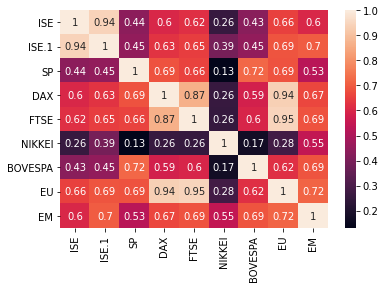

In [5]:
indices = ist_df.drop(['date'], axis=1)
corr_matrix = indices.corr()
corr_matrix, sns.heatmap(corr_matrix, annot=True)

# Data Preprocessing
Select the performance results for the EM and EU indices. Since, the performance results are expressed in decimals (because they are percentages) and are extremely small, we standardize the data, so that are gradients aren't negatively influenced by the magnitude of the performance rates.

In [6]:
X = ch.from_numpy(np.expand_dims(indices['EM'], 1))
y = ch.from_numpy(np.expand_dims(indices['EU'], 1))

# 
X_scaler, y_scaler = preprocessing.StandardScaler().fit(X), preprocessing.StandardScaler().fit(y)
X, y = ch.from_numpy(X_scaler.transform(X)).float(), ch.from_numpy(y_scaler.transform(y))

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [7]:
# truncate dataset
c = 1.0
phi = Left(Tensor([c]))
trunc_indices = phi(y).nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[trunc_indices], y[trunc_indices]

# experiment hyperparameters
args = Parameters({ 
    'alpha': Tensor([y_trunc.shape[0]/y.shape[0]]), 
    'phi': phi, 
    'epochs': 10,
    'num_workers': 2, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 2.0, 
    'var_lr': 1e-1,
    'lr': 1e-1,
    'unknown': True,
})

# Create Store for Experiment Results

In [10]:
STORE_PATH = '<Give Path to Store Data Here>'
STORE_PATH = '/home/pstefanou/test__'
STORE_TABLE_NAME = '<Give Store Table Name here>'
STORE_TABLE_NAME = 'test'

# create store
s = Store(STORE_PATH)
s.add_table(STORE_TABLE_NAME, { 
    'c': float, 
    'pred_var_mse': float, 
    'pred_param_mse': float, 
    'emp_var_mse': float, 
    'emp_param_mse': float,
})

Logging in: /home/pstefanou/test__/51db2fb2-f5b8-4916-a34e-f2e2e67ed8a0


# Run Procedure

In [15]:
# groun_truth parameters
lin_reg = LinearRegression() 
lin_reg.fit(X, y)
real_params = np.array([lin_reg.coef_, lin_reg.intercept_])
real_var = np.var(lin_reg.predict(X) - y.numpy(), 0)

# smallest number of surviving samples when varying truncation parameter C
num_samples = 199

C = [-1, -.75, -.5, -.25, 0, .25]
for i in range(20):
    for c in C: 
        # truncate
        phi = Left(Tensor([c]))
        trunc_indices = phi(y).nonzero(as_tuple=False).flatten()
        x_trunc, y_trunc = X[trunc_indices], y[trunc_indices]
        # add survival probability to hyperparameters
        alpha = x_trunc.shape[0]/X.shape[0]
        
        """
        If there are more than 199 samples within the truncation set, then select the first 
        199 samples from a random permutation of the survival set.
        """
        indices = ch.randperm(x_trunc.size(0))[:num_samples]
        x_trunc, y_trunc = x_trunc[indices], y_trunc[indices]

        # intialize datset
        dataset = TruncatedRegressionDataset(x_trunc, y_trunc.float(), bias=args.bias, unknown=args.unknown)
        S = DataLoader(dataset, batch_size=args.batch_size)

        trunc_reg = truncated_regression(phi=phi, alpha=alpha, unknown=args.unknown, lr=args.lr, var_lr=args.var_lr, num_samples=args.num_samples, epochs=args.epochs)
        results = trunc_reg.fit(S)

        with ch.no_grad():
            delphi_params = ch.cat([results.v*results.lambda_.inverse(), results.bias*results.lambda_.inverse()])
            delphi_var = results.lambda_.inverse()

            emp_params = ch.cat([dataset.w, dataset.w0.unsqueeze(0)])
            emp_var = dataset.lambda_.inverse()

            s[STORE_TABLE_NAME].append_row({ 
                'c': c, 
                'pred_param_mse': mean_squared_error(delphi_params, real_params), 
                'pred_var_mse': mean_squared_error(real_var, delphi_var),
                'emp_param_mse': mean_squared_error(emp_params, real_params), 
                'emp_var_mse': mean_squared_error(emp_var, real_var)
            })

/home/pstefanou/trunc-reg/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
Epoch:1 | Loss 0.1839 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.57it/s]
Epoch:2 | Loss 0.1837 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.07it/s]
Epoch:3 | Loss 0.1847 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 51.82it/s]
Epoch:4 | Loss 0.1869 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.37it/s]
Epoch:5 | Loss 0.1914 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.40it/s]
Epoch:6 | Loss 0.1978

Epoch:6 | Loss 0.1613 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.53it/s]
Epoch:7 | Loss 0.1616 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.53it/s]
Epoch:8 | Loss 0.1620 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.50it/s]
Epoch:9 | Loss 0.1623 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.09it/s]
Epoch:10 | Loss 0.1629 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.30it/s]
Epoch:1 | Loss 0.1454 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.62it/s]
Epoch:2 | Loss 0.1453 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.08it/s]
Epoch:3 | Loss 0.1456 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.42it/s]
Epoch:4 | Loss 0.1460 | Train1 0.482 | Train5 -

Epoch:4 | Loss 0.1623 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.56it/s]
Epoch:5 | Loss 0.1636 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 61.10it/s]
Epoch:6 | Loss 0.1648 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.86it/s]
Epoch:7 | Loss 0.1665 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.02it/s]
Epoch:8 | Loss 0.1686 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.61it/s]
Epoch:9 | Loss 0.1706 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.74it/s]
Epoch:10 | Loss 0.1720 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.31it/s]
Epoch:1 | Loss 0.1872 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.03it/s]
Epoch:2 | Loss 0.1874 | Train1 0.412 | Train5 -

Epoch:2 | Loss 0.1743 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.83it/s]
Epoch:3 | Loss 0.1753 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.45it/s]
Epoch:4 | Loss 0.1776 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.14it/s]
Epoch:5 | Loss 0.1816 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:6 | Loss 0.1861 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.63it/s]
Epoch:7 | Loss 0.1925 | Train1 0.518 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.75it/s]
Epoch:8 | Loss 0.2005 | Train1 0.553 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.50it/s]
Epoch:9 | Loss 0.2095 | Train1 0.578 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.52it/s]
Epoch:10 | Loss 0.2195 | Train1 0.588 | Train5 -

Epoch:10 | Loss 0.1213 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.13it/s]
Epoch:1 | Loss 0.1867 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.32it/s]
Epoch:2 | Loss 0.1868 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.60it/s]
Epoch:3 | Loss 0.1880 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.11it/s]
Epoch:4 | Loss 0.1924 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.98it/s]
Epoch:5 | Loss 0.1997 | Train1 0.457 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:6 | Loss 0.2092 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.73it/s]
Epoch:7 | Loss 0.2203 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.49it/s]
Epoch:8 | Loss 0.2341 | Train1 0.508 | Train5 -

Epoch:8 | Loss 0.1755 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.03it/s]
Epoch:9 | Loss 0.1824 | Train1 0.518 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.58it/s]
Epoch:10 | Loss 0.1898 | Train1 0.538 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.47it/s]
Epoch:1 | Loss 0.1323 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.97it/s]
Epoch:2 | Loss 0.1324 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.62it/s]
Epoch:3 | Loss 0.1328 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.09it/s]
Epoch:4 | Loss 0.1344 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.29it/s]
Epoch:5 | Loss 0.1382 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.66it/s]
Epoch:6 | Loss 0.1430 | Train1 0.447 | Train5 -

Epoch:6 | Loss 0.1593 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.98it/s]
Epoch:7 | Loss 0.1601 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.75it/s]
Epoch:8 | Loss 0.1603 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.79it/s]
Epoch:9 | Loss 0.1617 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.80it/s]
Epoch:10 | Loss 0.1647 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.90it/s]
Epoch:1 | Loss 0.1474 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.55it/s]
Epoch:2 | Loss 0.1483 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.51it/s]
Epoch:3 | Loss 0.1497 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.68it/s]
Epoch:4 | Loss 0.1514 | Train1 0.603 | Train5 -

Epoch:4 | Loss 0.1483 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.20it/s]
Epoch:5 | Loss 0.1508 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.26it/s]
Epoch:6 | Loss 0.1558 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.11it/s]
Epoch:7 | Loss 0.1596 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.91it/s]
Epoch:8 | Loss 0.1622 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.71it/s]
Epoch:9 | Loss 0.1642 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s]
Epoch:10 | Loss 0.1672 | Train1 0.623 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.86it/s]
Epoch:1 | Loss 0.1392 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.87it/s]
Epoch:2 | Loss 0.1393 | Train1 0.407 | Train5 -

Epoch:2 | Loss 0.1927 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.76it/s]
Epoch:3 | Loss 0.1926 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.49it/s]
Epoch:4 | Loss 0.1929 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.35it/s]
Epoch:5 | Loss 0.1942 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 68.01it/s]
Epoch:6 | Loss 0.1971 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.52it/s]
Epoch:7 | Loss 0.2019 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.43it/s]
Epoch:8 | Loss 0.2067 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.66it/s]
Epoch:9 | Loss 0.2121 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.45it/s]
Epoch:10 | Loss 0.2179 | Train1 0.462 | Train5 -

Epoch:10 | Loss 0.1967 | Train1 0.538 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.13it/s]
Epoch:1 | Loss 0.1959 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.40it/s]
Epoch:2 | Loss 0.1957 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.15it/s]
Epoch:3 | Loss 0.1971 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.43it/s]
Epoch:4 | Loss 0.1999 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.79it/s]
Epoch:5 | Loss 0.2039 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.82it/s]
Epoch:6 | Loss 0.2096 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.67it/s]
Epoch:7 | Loss 0.2161 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.27it/s]
Epoch:8 | Loss 0.2231 | Train1 0.518 | Train5 -

Epoch:8 | Loss 0.1790 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.16it/s]
Epoch:9 | Loss 0.1834 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 59.81it/s]
Epoch:10 | Loss 0.1875 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.68it/s]
Epoch:1 | Loss 0.1666 | Train1 0.387 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.17it/s]
Epoch:2 | Loss 0.1667 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.20it/s]
Epoch:3 | Loss 0.1671 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.72it/s]
Epoch:4 | Loss 0.1680 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.68it/s]
Epoch:5 | Loss 0.1698 | Train1 0.427 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 54.15it/s]
Epoch:6 | Loss 0.1732 | Train1 0.447 | Train5 -

Epoch:6 | Loss 0.1282 | Train1 0.442 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s]
Epoch:7 | Loss 0.1297 | Train1 0.477 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.01it/s]
Epoch:8 | Loss 0.1313 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.43it/s]
Epoch:9 | Loss 0.1332 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.50it/s]
Epoch:10 | Loss 0.1353 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.19it/s]
Epoch:1 | Loss 0.1562 | Train1 0.392 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.51it/s]
Epoch:2 | Loss 0.1569 | Train1 0.397 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.46it/s]
Epoch:3 | Loss 0.1579 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.79it/s]
Epoch:4 | Loss 0.1607 | Train1 0.427 | Train5 -

Epoch:4 | Loss 0.1383 | Train1 0.402 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.75it/s]
Epoch:5 | Loss 0.1392 | Train1 0.422 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.66it/s]
Epoch:6 | Loss 0.1403 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.60it/s]
Epoch:7 | Loss 0.1418 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.57it/s]
Epoch:8 | Loss 0.1437 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.42it/s]
Epoch:9 | Loss 0.1460 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.25it/s]
Epoch:10 | Loss 0.1480 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.40it/s]
Epoch:1 | Loss 0.1720 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.08it/s]
Epoch:2 | Loss 0.1719 | Train1 0.482 | Train5 -

Epoch:2 | Loss 0.1670 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.38it/s]
Epoch:3 | Loss 0.1681 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.17it/s]
Epoch:4 | Loss 0.1703 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.28it/s]
Epoch:5 | Loss 0.1720 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.03it/s]
Epoch:6 | Loss 0.1755 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.02it/s]
Epoch:7 | Loss 0.1809 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.38it/s]
Epoch:8 | Loss 0.1883 | Train1 0.518 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.55it/s]
Epoch:9 | Loss 0.1971 | Train1 0.523 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.65it/s]
Epoch:10 | Loss 0.2077 | Train1 0.513 | Train5 -

Epoch:10 | Loss 0.1295 | Train1 0.508 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.51it/s]
Epoch:1 | Loss 0.1469 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.14it/s]
Epoch:2 | Loss 0.1469 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.98it/s]
Epoch:3 | Loss 0.1478 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.45it/s]
Epoch:4 | Loss 0.1498 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 66.74it/s]
Epoch:5 | Loss 0.1531 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.57it/s]
Epoch:6 | Loss 0.1570 | Train1 0.603 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.38it/s]
Epoch:7 | Loss 0.1609 | Train1 0.608 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 67.86it/s]
Epoch:8 | Loss 0.1634 | Train1 0.613 | Train5 -

Epoch:8 | Loss 0.1629 | Train1 0.613 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 59.93it/s]
Epoch:9 | Loss 0.1642 | Train1 0.618 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.26it/s]
Epoch:10 | Loss 0.1675 | Train1 0.623 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 57.71it/s]
Epoch:1 | Loss 0.2024 | Train1 0.407 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 61.30it/s]
Epoch:2 | Loss 0.2024 | Train1 0.412 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.04it/s]
Epoch:3 | Loss 0.2029 | Train1 0.417 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 63.42it/s]
Epoch:4 | Loss 0.2050 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.59it/s]
Epoch:5 | Loss 0.2103 | Train1 0.437 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.30it/s]
Epoch:6 | Loss 0.2170 | Train1 0.447 | Train5 -

Epoch:6 | Loss 0.2099 | Train1 0.467 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.12it/s]
Epoch:7 | Loss 0.2144 | Train1 0.487 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.29it/s]
Epoch:8 | Loss 0.2213 | Train1 0.513 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.54it/s]
Epoch:9 | Loss 0.2283 | Train1 0.528 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.08it/s]
Epoch:10 | Loss 0.2330 | Train1 0.543 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 65.34it/s]
Epoch:1 | Loss 0.1903 | Train1 0.432 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.65it/s]
Epoch:2 | Loss 0.1905 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.46it/s]
Epoch:3 | Loss 0.1909 | Train1 0.447 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 64.12it/s]
Epoch:4 | Loss 0.1926 | Train1 0.467 | Train5 -

Epoch:4 | Loss 0.1444 | Train1 0.452 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.82it/s]
Epoch:5 | Loss 0.1449 | Train1 0.462 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.15it/s]
Epoch:6 | Loss 0.1460 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 56.71it/s]
Epoch:7 | Loss 0.1476 | Train1 0.482 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 58.30it/s]
Epoch:8 | Loss 0.1495 | Train1 0.492 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.25it/s]
Epoch:9 | Loss 0.1517 | Train1 0.497 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 53.53it/s]
Epoch:10 | Loss 0.1537 | Train1 0.503 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 60.42it/s]
Epoch:1 | Loss 0.1821 | Train1 0.382 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 2/2 [00:00<00:00, 62.02it/s]
Epoch:2 | Loss 0.1820 | Train1 0.397 | Train5 -

# Results

In [16]:
results = s[STORE_TABLE_NAME].df
results.head()

,c,pred_var_mse,pred_param_mse,emp_var_mse,emp_param_mse
0,-1.00,0.009598,0.005640,0.024601,0.012967
1,-0.75,0.024085,0.007474,0.032590,0.049974
2,-0.50,0.000968,0.003521,0.011563,0.067918
3,-0.25,0.043970,0.036641,0.050623,0.118320
4,0.00,0.043771,0.044661,0.049060,0.163357


# Plot Results

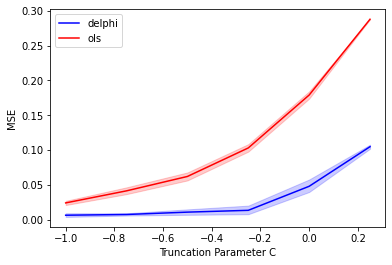

In [17]:
# plot results for regression parameter MSE
sns.lineplot(data=results, x='c', y='pred_param_mse', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='c', y='emp_param_mse', label='ols', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='MSE')
plt.show()

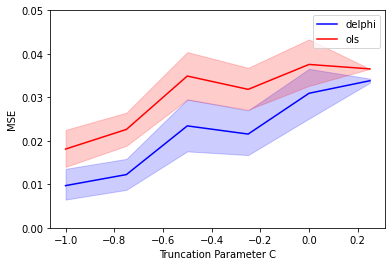

In [18]:
# plot results for regression noise variance MSE
sns.lineplot(data=results, x='c', y='pred_var_mse', label='delphi', color="blue")
ax = sns.lineplot(data=results, x='c', y='emp_var_mse', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='MSE')
ax.set(ylim=(0, .05))
plt.show()